In [1]:
import numpy as np
from numpy import asarray
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline 

import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, experimental
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras import optimizers


import import_ipynb
import sort_test_train_data
from sort_test_train_data import classes

Using TensorFlow backend.


importing Jupyter notebook from sort_test_train_data.ipynb


In [2]:
#there is total 31 classes with 300-500 images
NUM_CLASSES = 31
classes_to_use = random.sample(classes, NUM_CLASSES)

In [3]:
#GLOBAL CONSTANTS
IMAGE_RESIZE = 1024
CROP_LENGTH = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'

LOSS_METRICS = ['accuracy']

STEPS_PER_EPOCH_TRAINING = 10

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10

BATCH_SIZE = 100
BATCH_SIZE_TESTING = 1

In [4]:
#set model path
model_name = "Resnet50_" + str(NUM_EPOCHS) + "epochs_" + ".01LR" + "_CROP"
model_path = os.path.join(model_name)

In [5]:
#DEFINE MODEL
model = tf.keras.Sequential()

model.add(layers.experimental.preprocessing.RandomCrop(224,224))
# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained

model.layers[1].trainable = False

In [6]:
#get training data
train_datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory = 'train/',
                                                    classes = classes_to_use,
                                                    target_size = (IMAGE_RESIZE, IMAGE_RESIZE),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = BATCH_SIZE)

Found 8219 images belonging to 31 classes.


In [21]:
# #extend random crop to imagedatagenerator class

# def random_crop(img, random_crop_size):
#     # Note: image_data_format is 'channel_last'
#     assert img.shape[2] == 3
#     height, width = img.shape[0], img.shape[1]
#     dy, dx = random_crop_size
#     x = np.random.randint(0, width - dx + 1)
#     y = np.random.randint(0, height - dy + 1)
#     return img[y:(y+dy), x:(x+dx), :]


# def crop_generator(batches, crop_length):
#     """Take as input a Keras ImageGen (Iterator) and generate random
#     crops from the image batches generated by the original iterator.
#     """
#     while True:
#         batch_x, batch_y = next(batches)
#         batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
#         for i in range(batch_x.shape[0]):
#             batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
#         yield (batch_crops, batch_y)

# train_crop = crop_generator(train_generator, CROP_LENGTH)

In [7]:
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer= sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics= LOSS_METRICS)

In [ ]:
fit_history = model.fit(train_generator, epochs = NUM_EPOCHS)

Epoch 1/10
 4/83 [>.............................] - ETA: 28:51 - loss: 3.4352 - accuracy: 0.0250

/usr/local/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16/83 [====>.........................] - ETA: 29:58 - loss: 3.4336 - accuracy: 0.0325

/usr/local/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


83/83 [==============================] - 2212s 27s/step - loss: 3.4331 - accuracy: 0.0341
Epoch 2/10
83/83 [==============================] - 30687s 370s/step - loss: 3.4324 - accuracy: 0.0377
Epoch 3/10
83/83 [==============================] - 2794s 34s/step - loss: 3.4321 - accuracy: 0.0384
Epoch 4/10
65/83 [======================>.......] - ETA: 28:13 - loss: 3.4320 - accuracy: 0.0357

In [45]:
#save model 
model.save(model_path)

INFO:tensorflow:Assets written to: Resnet50_10epochs_.01LRCROP/assets


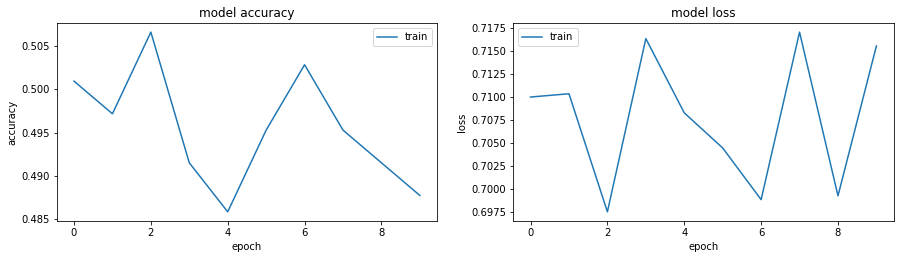

In [46]:
#plot loss and accuracy
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])    
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])    
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train']) 

plt.savefig(os.path.join(model_path, 'accuracy_loss.png'))
#plt.show()

In [47]:
test_generator = train_datagen.flow_from_directory(directory = 'test/',
                                                    classes = classes_to_use,
                                                    target_size = (IMAGE_RESIZE, IMAGE_RESIZE),
                                                    color_mode = 'rgb',
                                                    class_mode = 'categorical',
                                                    batch_size = BATCH_SIZE_TESTING)


Found 165 images belonging to 2 classes.


In [12]:
test_loss, test_acc = model.evaluate(test_generator, batch_size = BATCH_SIZE_TESTING)

2851/2851 [==============================] - 252s 88ms/step - loss: 3.4208 - accuracy: 0.0540


In [13]:
test_generator.reset()

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
2851/2851 [==============================] - 255s 89ms/step


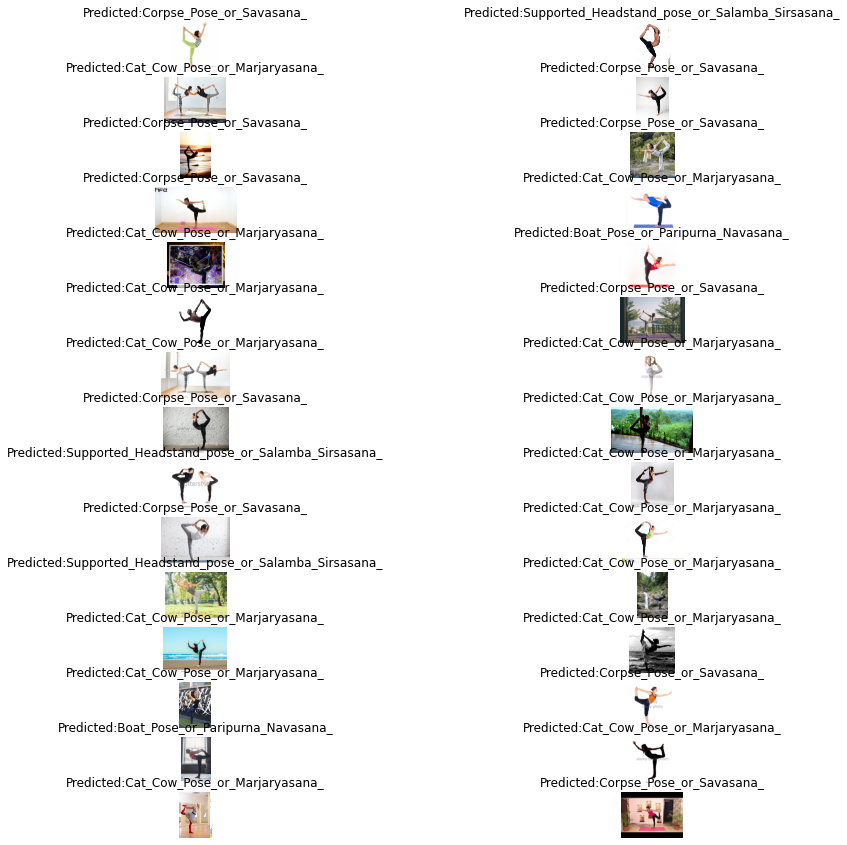

In [14]:
TEST_DIR = 'test/'
f, ax = plt.subplots(15, 2, figsize = (15, 15))

for i in range(0,30):
    imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[i])
    imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
    
    predicted_class = classes_to_use[predicted_class_indices[i]]

    ax[i//2, i%2].imshow(imgRGB)
    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].set_title("Predicted:{}".format(predicted_class))    

plt.show()

In [15]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)

print(results_df)

       id  label
450     1      8
379     1     18
378     1     18
377     1     12
376     1     12
...   ...    ...
845   672     12
846   673     12
2682  686     18
2683  687     13
847   694     18

[2851 rows x 2 columns]
